In [51]:
import pickle
import xarray as xr
import cartopy as cp
import matplotlib.pyplot as plt
import numpy as np

import cartopy
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.patches import Rectangle


## open data

In [52]:
with open('./sampledat/Nanoose_9_CastCTD_2011-03-08_2014h.pickle', 'rb') as pickle_file:
    model = pickle.load(pickle_file)

obs = xr.open_dataset('./sampledat/Nanoose_9_CastCTD_2011-03-08_2014h.nc')

obs

<xarray.Dataset>
Dimensions:      (pressure: 381, single: 1)
Dimensions without coordinates: pressure, single
Data variables:
    Pres         (pressure) float32 ...
    temperature  (pressure) float64 ...
    cTemp        (pressure) float64 ...
    salinity     (pressure) float64 ...
    aSal         (pressure) float64 ...
    pDen         (pressure) float64 ...
    time         (single) datetime64[ns] ...
    depth        (single) float32 ...
    latitude     (single) float32 ...
    longitude    (single) float32 ...

In [53]:
model

{'z': masked_array(data=[0.4992295503616333, 1.4976907968521118,
                    2.496157646179199, 3.4946353435516357,
                    4.493133544921875, 5.491672039031982, 6.49029016494751,
                    7.489060878753662, 8.488131523132324,
                    9.487785339355469, 10.488572120666504,
                    11.491570472717285, 12.498869895935059,
                    13.514547348022461, 14.546524047851562,
                    15.610187530517578, 16.735336303710938,
                    17.97937774658203, 19.451753616333008,
                    21.357006072998047, 24.0631046295166,
                    28.186399459838867, 34.63228988647461,
                    44.449100494384766, 58.39418029785156, 76.467529296875,
                    97.91179656982422, 121.67865753173828,
                    146.86273193359375, 172.84762573242188,
                    199.26539611816406, 225.91151428222656,
                    252.67652893066406, 279.5030212402344,
             

# plot ctd location on standard map and on subset

/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


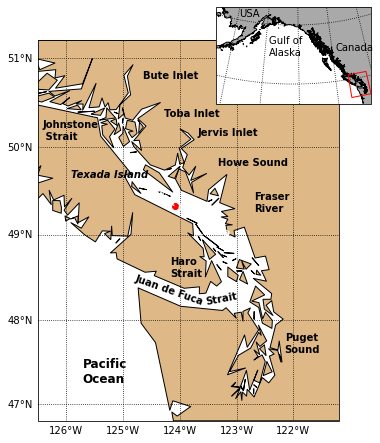

In [54]:


subdomain = [114, 397, 334, 897]
fig = plt.figure(figsize=(9, 7))
gs = plt.GridSpec(1, 1)#, width_ratios=[1.8, 1], wspace=0.13)

# Map Left
xlim, ylim = [-126.5, -121.2], [46.8, 51.2]
ax = fig.add_subplot(gs[0], projection=crs.Mercator(np.mean(xlim), *ylim))
ax.set_extent(xlim + ylim)
#full (low for easy render)
ax.add_feature(feature.GSHHSFeature('low', edgecolor='k', facecolor='burlywood'))

xlocs, ylocs = [np.arange(np.floor(l[0]), np.ceil(l[1])+1) for l in [xlim, ylim]]
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, xlocs=xlocs, ylocs=ylocs)
gl.xformatter, gl.yformatter = LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.xlabels_top, gl.ylabels_right = False, False

ax.text(0.15, 0.1, 'Pacific\nOcean', weight='bold', fontsize = 12, transform=ax.transAxes)
ax.text(0.32, 0.307, 'Juan de Fuca', weight='bold', transform=ax.transAxes, rotation=-19.5)
ax.text(0.555, 0.305, 'Strait', weight='bold', transform=ax.transAxes, rotation=10.5)
ax.text(0.82, 0.18, 'Puget\nSound', weight='bold', transform=ax.transAxes)

ax.text(0.355, 0.4851, 'Strait of Georgia', weight='bold', transform=ax.transAxes, rotation=-30, color='w')
#ax.text(0.010, 0.755, 'Johnstone', weight='bold', transform=ax.transAxes, rotation=-20)
ax.text(0.015, 0.740, 'Johnstone \n Strait ', weight='bold', transform=ax.transAxes, rotation=-0)
#ax.text(0.16, 0.675, 'Strait', weight='bold', transform=ax.transAxes, rotation=-60)

ax.text(0.44, 0.38, 'Haro\nStrait', weight='bold', transform=ax.transAxes)


ax.text(0.72, 0.55, 'Fraser\nRiver', weight='bold', transform=ax.transAxes)
ax.text(0.35, 0.9, 'Bute Inlet', weight='bold', transform=ax.transAxes)
ax.text(0.42, 0.80, 'Toba Inlet', weight='bold', transform=ax.transAxes)
ax.text(0.53, 0.75, 'Jervis Inlet', weight='bold', transform=ax.transAxes)
ax.text(0.60, 0.67, 'Howe Sound', weight='bold', transform=ax.transAxes)
ax.text(0.11, 0.64, 'Texada Island', weight='bold',fontstyle="italic", 
        color = 'k', fontsize = 10, transform=ax.transAxes)


ax.plot(obs['longitude'][:], obs['latitude'][:], 'ro', transform=crs.PlateCarree())


#Map Inset
xmap, ymap = [-161, -122], [45, 62]
ax2 = fig.add_axes([0.555, 0.75, 0.24, 0.2], projection=crs.LambertConformal(np.mean(xmap), np.mean(ymap)))
ax2.set_extent(xmap + ymap)
ax2.add_feature(feature.GSHHSFeature('low', edgecolor='k', facecolor='darkgray'))
ax2.add_patch(Rectangle(
    (xlim[0], ylim[0]), int(np.diff(xlim)), int(np.diff(ylim)),
    transform=crs.PlateCarree(), fill=False, edgecolor='r', zorder=10,
))



ax2.text(0.34, 0.5, 'Gulf of\nAlaska', transform=ax2.transAxes)
ax2.text(0.77, 0.55, 'Canada', transform=ax2.transAxes)
ax2.text(0.15, 0.9, 'USA', transform=ax2.transAxes)



xticks, yticks = list(range(-170, -100, 10)), list(range(40, 80, 10))
ax2.gridlines(linestyle=":", color='k', xlocs=xticks, ylocs=yticks)
ax2.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax2.yaxis.set_major_formatter(LATITUDE_FORMATTER)
fig.canvas.draw()

#ax.set_title('Nanoose CTD observation location (red) \n on standard Salish Sea map',zorder = 100)

#lct.lambert_xticks(ax, xticks)
#lct.lambert_yticks(ax, yticks)

# # Colorbar
# cax = fig.add_axes([0.15, 0.06, 0.73, 0.025])
# fig.colorbar(c, cax=cax, orientation='horizontal', label='surface diatom concentration (mmol N m$^{-3}$)')

# fig.savefig('./paper_figs/MF01-domain.jpg', bbox_inches='tight', dpi = 300)

/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, 'Nanoose CTD observation location (red) \n in Strait of Georgia')

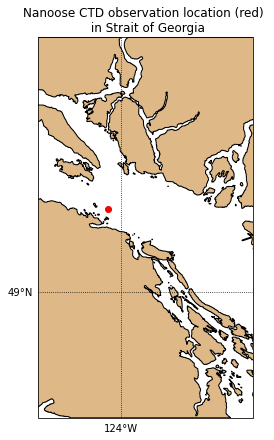

In [55]:


subdomain = [114, 397, 334, 897]
fig = plt.figure(figsize=(9, 7))
gs = plt.GridSpec(1, 1)#, width_ratios=[1.8, 1], wspace=0.13)

# Map Left
xlim, ylim = [-124.5, -123.2], [48.5, 50]
ax = fig.add_subplot(gs[0], projection=crs.Mercator(np.mean(xlim), *ylim))
ax.set_extent(xlim + ylim)
#full (low for easy render)
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='burlywood'))


    
xlocs, ylocs = [np.arange(np.floor(l[0]), np.ceil(l[1])+1) for l in [xlim, ylim]]
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, xlocs=xlocs, ylocs=ylocs)
gl.xformatter, gl.yformatter = LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.xlabels_top, gl.ylabels_right = False, False


ax.plot(obs['longitude'][:], obs['latitude'][:], 'ro', transform=crs.PlateCarree())

fig.canvas.draw()

ax.set_title('Nanoose CTD observation location (red) \n in Strait of Georgia',zorder = 100)

#lct.lambert_xticks(ax, xticks)
#lct.lambert_yticks(ax, yticks)

# # Colorbar
# cax = fig.add_axes([0.15, 0.06, 0.73, 0.025])
# fig.colorbar(c, cax=cax, orientation='horizontal', label='surface diatom concentration (mmol N m$^{-3}$)')

# fig.savefig('./paper_figs/MF01-domain.jpg', bbox_inches='tight', dpi = 300)

Text(0.5, 0, 'salinity')

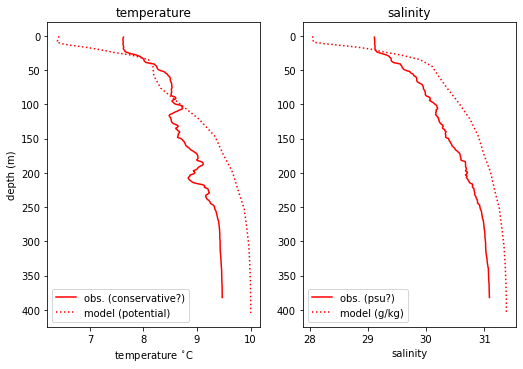

In [56]:
model

fact = 0.7
fig, axs = plt.subplots(1,2, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(obs['cTemp'], obs['Pres'], 'r-', label = 'obs. (conservative?)')
axs[0].plot(model['pTemp'], model['z'], 'r:',  label = 'model (potential)')
axs[0].invert_yaxis()
axs[0].legend()
axs[0].set_title('temperature')

axs[1].plot(obs['salinity'], obs['Pres'], 'r-', label = 'obs. (psu?)')
axs[1].plot(model['salinity'], model['z'], 'r:',  label = 'model (g/kg)')
axs[1].invert_yaxis()
axs[1].legend()
axs[1].set_title('salinity')

axs[0].set_ylabel('depth (m)')
axs[0].set_xlabel('temperature $^{\circ}$C')
axs[1].set_xlabel('salinity')